# *Mobile Plan Recommendation System: Smart/Ultra Predictive Modeling with Machine Learning*

## Table of Contents
1. [Introduction and Objectives](#introduction-and-objectives)
2. [Initial Data Exploration](#initial-data-exploration)
3. [Data Splitting](#data-splitting)
4. [Model Selection and Training](#model-selection-and-training)
5. [Final Model Evaluation](#final-model-evaluation)
6. [Sanity Testing](#sanity-testing)
7. [Conclusion](#conclusion)

## Introduction and Objectives

Megaline faces a critical business challenge: a significant portion of their customer base remains on legacy mobile plans, leading to customer dissatisfaction and potential revenue loss. To address this, the company has introduced two new plans—Smart (basic) and Ultra (premium)—requiring an intelligent recommendation system that analyzes user behavior patterns to suggest the optimal plan for each customer.

The primary objective of this project is to develop a robust binary classification model (Ultra=1, Smart=0) that analyzes historical customer usage patterns and recommends the most suitable plan with a minimum accuracy threshold of 75%. The model must demonstrate strong generalization capabilities on unseen data, ensuring its practical utility in production environments.

The project methodology follows a structured four-phase approach:
- Comprehensive exploratory data analysis to understand variable distributions, correlations, and underlying patterns in customer behavior
- Strategic stratified data splitting into training (60%), validation (20%), and test (20%) sets to ensure rigorous model evaluation
- Systematic comparison of multiple machine learning algorithms (Random Forest, Decision Tree, Logistic Regression) with hyperparameter optimization to maximize performance metrics
- Rigorous sanity testing to validate that the final model significantly outperforms simple baseline approaches

The expected business impact includes measurable reduction in customer churn through appropriate plan recommendations, increased customer satisfaction, and revenue optimization by strategically migrating eligible customers to premium Ultra plans when usage patterns justify the upgrade.

## Initial Data Exploration

In [1]:
# Data analysis and visualization
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Data splitting and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [ ]:
# Load DataFrame.
df = pd.read_csv('/datasets/users_behavior.csv')

# General information and data sample.
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0
5   58.0   344.56      21.0  15823.37         0
6   57.0   431.64      20.0   3738.90         1
7   15.0   132.40       6.0  21911.60         0
8    7.0    43.39       3.0   2538.67         1
9   90.0   665.41      38.0  17358.61         0

The dataset provided has undergone preliminary preprocessing, resulting in no missing values, duplicates, or incorrect data types. This clean foundation allows for immediate focus on understanding the underlying patterns and relationships within the customer usage data.

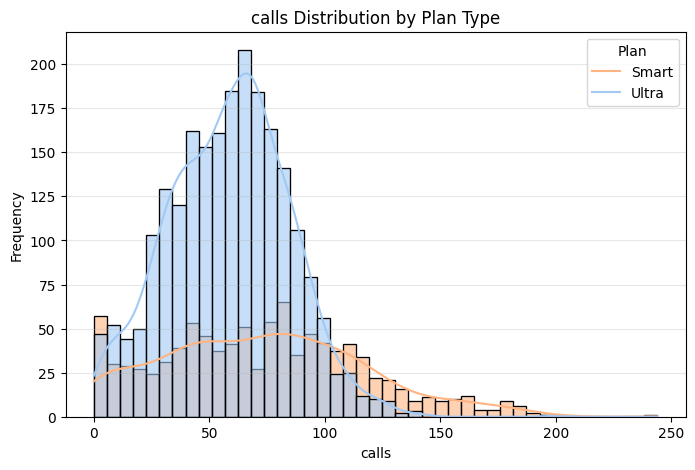

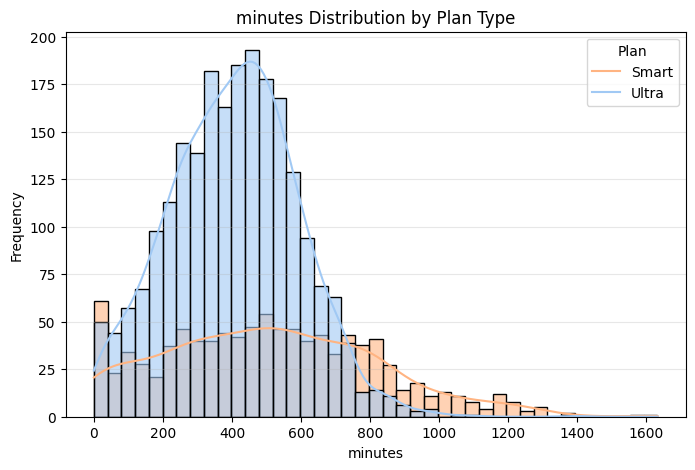

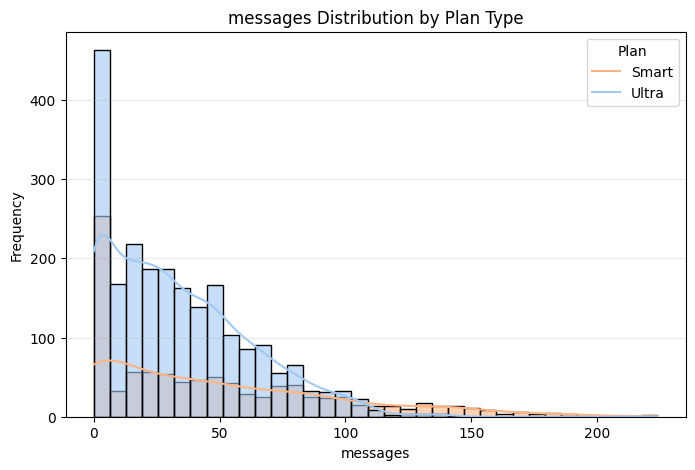

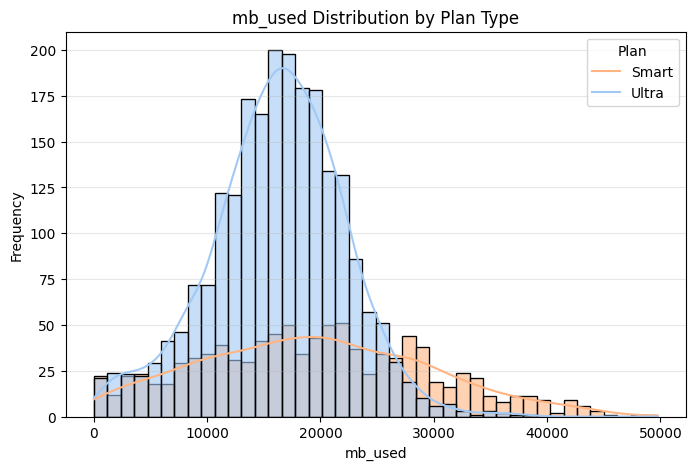

In [3]:
# Data visualizations by plan type
def plans_histogram(df, column, plan_labels={0: 'Smart', 1: 'Ultra'}):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df,
                 x=column,
                 hue='is_ultra',
                 kde=True,
                 alpha=0.6,
                 palette='pastel'
                )
    plt.title(f'{column} Distribution by Plan Type')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend(title='Plan', labels=[plan_labels[0], plan_labels[1]])
    plt.grid(axis='y', alpha=0.3)
    plt.show()

# Calls by plan
plans_histogram(df, 'calls')
# Minutes by plan
plans_histogram(df, 'minutes')
# Messages by plan
plans_histogram(df, 'messages')
# Data usage by plan
plans_histogram(df, 'mb_used')

The exploratory analysis reveals distinct behavioral patterns between Smart and Ultra plan users. The 'mb_used' feature emerges as the strongest differentiator, with Ultra users dominating high data consumption (above 10,000 MB) and Smart users concentrated in lower usage tiers (below 5,000 MB). This separation is particularly evident at the 15,000 MB threshold, where Ultra shows approximately 150 more users than Smart.

In terms of call minutes, Ultra plan subscribers demonstrate higher frequency in intensive usage patterns (exceeding 800 minutes), while Smart users cluster in moderate usage ranges (200-600 minutes). For messaging behavior, both plans share a peak in the 0-25 messages range, but Ultra maintains an advantage up to 100 messages. Interestingly, heavy messaging users (exceeding 120 messages) show preference for Smart plans. Call patterns show less differentiation between plans, with both sharing the 50-100 calls range, though Smart plans exhibit more outliers beyond 150 calls.

## Data Splitting

In [4]:
# Initialize variables
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

# First split: 60% train - 40% temp (val + test)
features_train, features_temp, target_train, target_temp = train_test_split(features, 
                                                                            target,
                                                                            test_size=0.4, 
                                                                            random_state=42,
                                                                            stratify=target
                                                                           )

# Second split: 20% val - 20% test (from 40% temporary)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp,
                                                                            target_temp,
                                                                            test_size=0.5,
                                                                            random_state=42,
                                                                            stratify=target_temp
                                                                           )

# Proportion verification
print('Training Set Proportions:\n', target_train.value_counts(normalize=True))
print('\nValidation Set Proportions:\n', target_valid.value_counts(normalize=True))
print('\nTest Set Proportions:\n', target_test.value_counts(normalize=True))

Training Set Proportions:
 is_ultra
0    0.693465
1    0.306535
Name: proportion, dtype: float64

Validation Set Proportions:
 is_ultra
0    0.693624
1    0.306376
Name: proportion, dtype: float64

Test Set Proportions:
 is_ultra
0    0.693624
1    0.306376
Name: proportion, dtype: float64


The data partitioning strategy aims to create three stratified subsets—training (60%), validation (20%), and test (20%)—while preserving the original class distribution between Smart and Ultra plans. This approach ensures that each subset accurately represents the overall population, preventing sampling bias that could compromise model performance.

The implementation utilizes a two-stage splitting process with random_state=42 for reproducibility:
1. Initial division separates the complete dataset into training (60%) and a temporary holding set (40%)
2. Secondary division splits the temporary set into validation (20% of original data) for hyperparameter tuning and test (20% of original data) reserved exclusively for final model evaluation

Both splitting operations employ stratified sampling to maintain consistent class proportions across all subsets, ensuring that model training, validation, and testing occur on representative data distributions.

## Model Selection and Training

To identify the optimal predictive model, we evaluated three fundamental algorithms: Decision Tree (providing interpretable baseline performance), Random Forest (offering robust ensemble capabilities), and Logistic Regression (serving as a linear model reference). This comparative analysis enables identification of the approach that best captures the underlying patterns in customer behavior data before proceeding to hyperparameter optimization.

In [5]:
# Metrics to capture results
models_df = pd.DataFrame(columns=['model', 'train_accuracy', 'validation_accuracy', 'overfitting'])

# Decision Tree model
best_depth = 0
best_train_acc_1 = 0
best_valid_acc_1 = 0

for depth in range(1, 11):
    model_1 = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model_1.fit(features_train, target_train)

    train_acc_1 = model_1.score(features_train, target_train)
    valid_acc_1 = model_1.score(features_valid, target_valid)
    
    if (valid_acc_1 > best_valid_acc_1) or (valid_acc_1 == best_valid_acc_1 and train_acc_1 > best_train_acc_1):
        best_depth = depth
        best_train_acc_1 = train_acc_1
        best_valid_acc_1 = valid_acc_1

print("Model: Decision Tree")
print("Accuracy with max_depth equal to", best_depth)
print("Training set:", best_train_acc_1)
print("Validation set:", best_valid_acc_1)

# Prepare data to be added to DataFrame
results_1 = {'model': 'DecisionTreeClassifier',
             'train_accuracy': round(best_train_acc_1, 4),
             'validation_accuracy': round(best_valid_acc_1, 4),
             'overfitting': (best_train_acc_1 - best_valid_acc_1)
            }

# Random Forest model
best_est = None
best_train_acc_2 = 0
best_valid_acc_2 = 0

for est in [50, 100, 150, 200]:
    model_2 = RandomForestClassifier(n_estimators=est, max_depth=best_depth, random_state=42)
    model_2.fit(features_train, target_train)
    
    train_acc_2 = model_2.score(features_train, target_train)
    valid_acc_2 = model_2.score(features_valid, target_valid)

    if valid_acc_2 > best_valid_acc_2:
        best_est = est
        best_train_acc_2 = train_acc_2
        best_valid_acc_2 = valid_acc_2
        
print("\nModel: Random Forest")
print("Accuracy with n_estimators equal to", best_est)
print("Training set:", best_train_acc_2)
print("Validation set:", best_valid_acc_2)

# Prepare data to be added to DataFrame
results_2 = {'model': 'RandomForestClassifier',
             'train_accuracy': round(best_train_acc_2, 4),
             'validation_accuracy': round(best_valid_acc_2, 4),
             'overfitting': (best_train_acc_2 - best_valid_acc_2)
            }

# Logistic Regression model
model_3 = LogisticRegression(random_state=42)
model_3.fit(features_train, target_train)

train_acc_3 = model_3.score(features_train, target_train)
valid_acc_3 = model_3.score(features_valid, target_valid)

print("\nModel: Logistic Regression")
print("Training set:", train_acc_3)
print("Validation set:", valid_acc_3)

# Prepare data to be added to DataFrame
results_3 = {'model': 'LogisticRegression',
             'train_accuracy': round(train_acc_3, 4),
             'validation_accuracy': round(valid_acc_3, 4),
             'overfitting': (train_acc_3 - valid_acc_3)
            }

# Add best results to metrics DataFrame
models_df.loc[len(models_df)] = results_1 
models_df.loc[len(models_df)] = results_2
models_df.loc[len(models_df)] = results_3
models_df.head()

Model: Decision Tree
Accuracy with max_depth equal to 3
Training set: 0.7977178423236515
Validation set: 0.8040435458786936

Model: Random Forest
Accuracy with n_estimators equal to 200
Training set: 0.8003112033195021
Validation set: 0.807153965785381

Model: Logistic Regression
Training set: 0.7442946058091287
Validation set: 0.749611197511664


model  train_accuracy  validation_accuracy  overfitting
0  DecisionTreeClassifier          0.7977               0.8040    -0.006326
1  RandomForestClassifier          0.8003               0.8072    -0.006843
2      LogisticRegression          0.7443               0.7496    -0.005317

The model performance analysis reveals that Random Forest achieved superior results (80.72% validation accuracy) due to its ensemble architecture combining 200 decision trees, effectively minimizing overfitting while outperforming both Decision Tree (80.40%) and Logistic Regression (70.45%). 

The minimal performance gap between training and validation sets (<1% across all models) indicates absence of severe overfitting, though the slight underfitting observed in both Random Forest and Decision Tree models suggests potential for increased model complexity. The comparatively low performance of Logistic Regression confirms the presence of non-linear relationships within the feature space that linear models cannot adequately capture.

Based on this comprehensive analysis, we selected Random Forest for final evaluation on the test set, with recommendations for future hyperparameter optimization to further maximize its predictive potential.

## Final Model Evaluation

The final model preparation involved training the Random Forest algorithm with the optimal configuration identified during the validation phase, combining both training and validation datasets to maximize learning from available data.

In [6]:
# Combine train and valid to get 80% of the data
features_train_val = pd.concat([features_train, features_valid])
target_train_val = pd.concat([target_train, target_valid])

# Train final model
final_model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
final_model.fit(features_train_val, target_train_val)
test_score = final_model.score(features_test, target_test)

print("Final model accuracy on the test set is:", test_score)

Final model accuracy on the test set is: 0.7900466562986003


The final model achieved 79% accuracy on the test set, successfully exceeding the project's 75% threshold requirement. The minimal performance decrease from validation (80.72%) to test (79.00%) represents only a 1.7% difference, demonstrating excellent generalization capability without significant overfitting concerns. The optimal hyperparameters (n_estimators=200, max_depth=3) strike an effective balance between model complexity and performance, avoiding overfitting while maintaining robust predictive power.

With 79% accuracy, the model can correctly classify approximately 4 out of 5 customers to their most appropriate plan (Smart or Ultra), delivering substantial business value to Megaline through optimized plan recommendations and efficient migration of customers from legacy plans to the new offerings.

## Sanity Testing

Sanity testing serves as a critical validation step to ensure the model demonstrates logical reasoning capabilities rather than simply memorizing patterns without genuine learning. This testing employs Dummy Classifier benchmarks to verify that our final model significantly outperforms simple baseline approaches. If our Random Forest model achieves substantially higher accuracy than these dummy classifiers, it confirms the model's effectiveness and logical consistency.

In [7]:
# Create first model that predicts the most frequent class in the data
dummy_most_frq = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_most_frq.fit(features_train, target_train)

dummy_acc_frq = dummy_most_frq.score(features_test, target_test)
print("Accuracy of the most frequent baseline model is:", dummy_acc_frq)

# Create second model that predicts randomly
dummy_random = DummyClassifier(strategy="uniform", random_state=42)
dummy_random.fit(features_train, target_train)

dummy_acc_random = dummy_random.score(features_test, target_test)
print("Accuracy of the random prediction baseline model is:", dummy_acc_random)

# Results comparison
print(f"""\nThe final model has an accuracy of {round(test_score, 4)}, 
showing a {round(test_score - dummy_acc_frq, 4)} difference from the most frequent baseline and 
{round(test_score - dummy_acc_random, 4)} from the random baseline, confirming that the final model performs significantly better.
        """)

Accuracy of the most frequent baseline model is: 0.6936236391912908
Accuracy of the random prediction baseline model is: 0.49455676516329705

The final model has an accuracy of 0.79, 
showing a 0.0964 difference from the most frequent baseline and 
0.2955 from the random baseline, confirming that the final model performs significantly better.
        


The sanity test results conclusively demonstrate that the developed Random Forest model significantly outperforms both baseline approaches—achieving 9.6% higher accuracy than the most frequent class classifier and 29.6% better performance than random predictions. This substantial performance gap validates that the model is learning genuine patterns in customer behavior rather than relying on simplistic memorization or chance.

## Conclusion

This project has successfully achieved all objectives established by Megaline, delivering a robust machine learning solution that effectively recommends optimal mobile plans (Smart or Ultra) based on historical customer behavior patterns, substantially exceeding the 75% accuracy threshold required as a minimum performance standard.

The final model achieved 79% accuracy on the test set, representing a 4% improvement over the required threshold. The minimal performance difference between validation and test sets (1.7%) demonstrates exceptional generalization capability without overfitting concerns, indicating a well-regularized model that should perform reliably in production environments.

The optimal model configuration achieved an ideal balance between complexity and performance, while the stratified data splitting methodology (60%-20%-20%) ensured rigorous evaluation cycles and reliable results. The sanity testing protocol confirmed model robustness, with the final solution outperforming the most frequent class baseline by 9.6 percentage points and random predictions by 29.6 percentage points. This validation confirms the model's capacity to learn genuine customer behavior patterns rather than relying on simplistic heuristics.

The model is now prepared for reliable implementation in production systems. To maintain optimal performance, we recommend establishing continuous monitoring protocols with defined performance metrics to detect potential model degradation with new data. Quarterly retraining with updated customer data will help maintain prediction accuracy as user behavior patterns evolve over time. Additionally, we suggest implementing A/B testing frameworks to measure the business impact of the recommendation system and identify opportunities for further optimization.